# Questão 3

a) Implemente e treine um autoencoder utilizando o dataset Fashion-MNIST, disponível em:
https://www.kaggle.com/datasets/zalando-research/fashionmnist. O objetivo deste exercício é
compreender como esse tipo de rede neural é capaz de aprender representações comprimidas
de dados e realizar reconstruções a partir dessas representações. O autoencoder pode ser
construído utilizando apenas camadas densas (fully connected) ou, alternativamente, camadas
convolucionais e deconvolucionais.
Após o treinamento, selecione 10 imagens do conjunto de teste e utilize o modelo treinado para
gerar as reconstruções correspondentes. Apresente os resultados visualmente, exibindo lado a
lado as imagens originais e suas respectivas reconstruções, de modo que seja possível avaliar
qualitativamente o desempenho do autoencoder. Apresente também a curva do erro médio ao
longo do treinamento.

(b) Complete o exercício da questão 3(a) adicionando ruído aleatório às imagens de entrada,
com o objetivo de treinar um denoising autoencoder. Após o treinamento, utilize as 10 imagens
selecionadas na questão anterior (com o ruído aplicado) e apresente os resultados
visualmente, exibindo lado a lado as imagens originais e suas respectivas reconstruções. Avalie
qualitativamente o desempenho do modelo em remover o ruído e preservar as características
das imagens originais.

## a)

In [129]:
import kagglehub
from keras.layers import Dense, Input, Conv2D, LSTM, MaxPool2D, UpSampling2D
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from numpy import argmax, array_equal
import matplotlib.pyplot as plt
from keras import Input, Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from random import randint
from skimage.util import random_noise
import pandas as pd
import numpy as np
from PIL import Image

In [43]:
# Download latest version
path = kagglehub.dataset_download("zalando-research/fashionmnist")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/zalando-research/fashionmnist/versions/4


In [44]:
# Carrega os dados de treinamento
train_df = pd.read_csv(path + '/fashion-mnist_train.csv')

# Carrega os dados de teste
test_df = pd.read_csv(path + '/fashion-mnist_test.csv')

In [45]:
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [46]:
X_train = train_df.drop('label', axis=1).values
y_train = train_df['label'].values

X_test = test_df.drop('label', axis=1).values
y_test = test_df['label'].values

In [47]:
X_train = X_train / 255
X_test = X_test / 255

In [49]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

In [50]:
X_train = X_train.reshape(-1, 784)
X_val = X_val.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

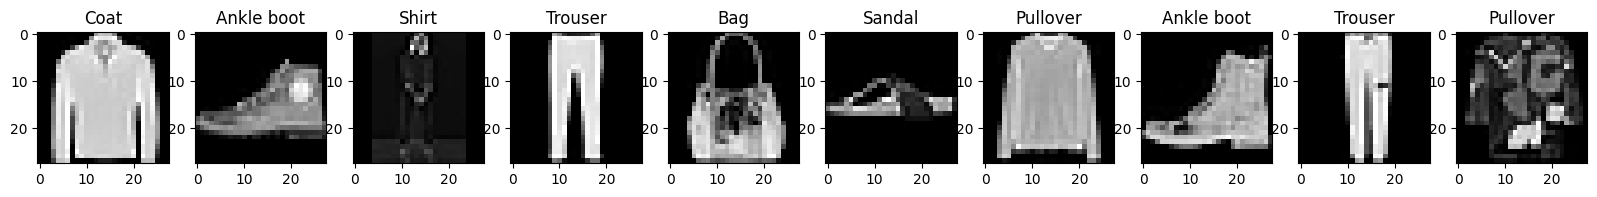

In [63]:
labeldict = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

fig, ax = plt.subplots(1, 10, figsize=(20, 2))
for i in range(10):
    # Reshape the image before displaying
    image = X_train[i].reshape(28, 28)
    ax[i].imshow(image, cmap='gray')
    ax[i].set_title(labeldict[y_train[i]])

In [53]:
## input layer
input_layer = Input(shape=(784,))

## encoding architecture
encode_layer1 = Dense(1500, activation='relu')(input_layer)
encode_layer2 = Dense(1000, activation='relu')(encode_layer1)
encode_layer3 = Dense(500, activation='relu')(encode_layer2)

## latent view
latent_view   = Dense(10, activation='sigmoid')(encode_layer3)

## decoding architecture
decode_layer1 = Dense(500, activation='relu')(latent_view)
decode_layer2 = Dense(1000, activation='relu')(decode_layer1)
decode_layer3 = Dense(1500, activation='relu')(decode_layer2)

## output layer
output_layer  = Dense(784)(decode_layer3)

model = Model(input_layer, output_layer)

In [54]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 1500)                │       1,177,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 1000)                │       1,501,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 500)                 │         500,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 10)                  │           5,010 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 500)                 │           5,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 1000)                │         501,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 1500)                │       1,501,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 784)                 │       1,176,784 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,368,794 (24.30 MB)

 Trainable params: 6,368,794 (24.30 MB)

 Non-trainable params: 0 (0.00 B)

In [70]:
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')
model.fit(X_train, X_train, epochs=5, batch_size=2048, validation_data=(X_val, X_val), callbacks=[early_stopping])

Epoch 1/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - loss: 0.0838 - mae: 0.1854 - val_loss: 0.0313 - val_mae: 0.1194
Epoch 2/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - loss: 0.0281 - mae: 0.1095 - val_loss: 0.0230 - val_mae: 0.0935
Epoch 3/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - loss: 0.0222 - mae: 0.0914 - val_loss: 0.0204 - val_mae: 0.0865
Epoch 4/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - loss: 0.0199 - mae: 0.0852 - val_loss: 0.0192 - val_mae: 0.0831
Epoch 5/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - loss: 0.0189 - mae: 0.0822 - val_loss: 0.0187 - val_mae: 0.0811


In [71]:
model.history.history.keys()

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])

In [ ]:
# plot da curva do erro médio
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [59]:
preds = model.predict(X_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step


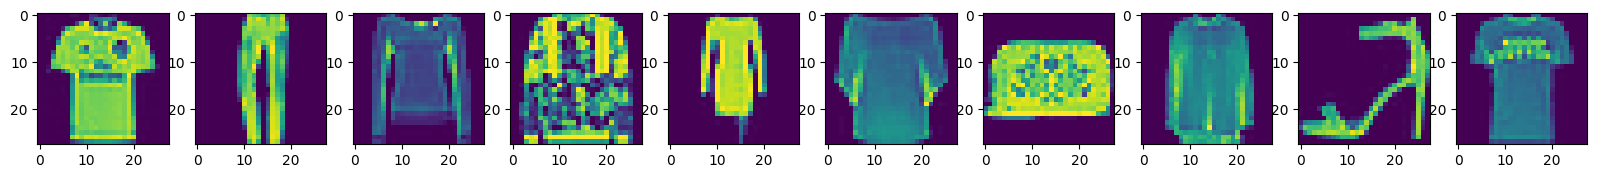

In [60]:
f, ax = plt.subplots(1,10)
f.set_size_inches(20, 20)
for i in range(10):
    ax[i].imshow(X_test[i].reshape(28, 28))
plt.show()

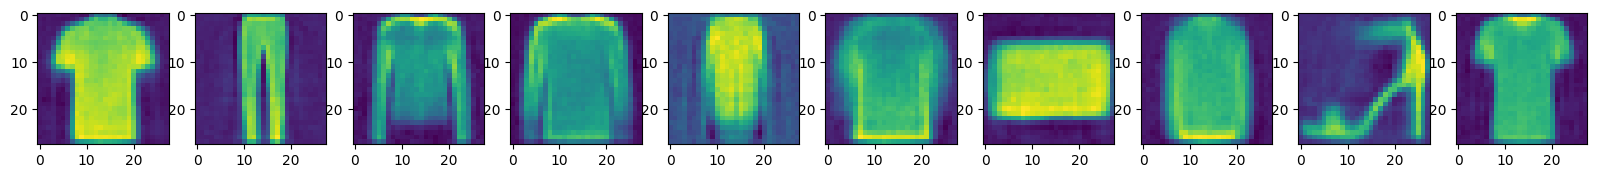

In [61]:
f, ax = plt.subplots(1,10)
f.set_size_inches(20, 20)
for i in range(10):
    ax[i].imshow(preds[i].reshape(28, 28))
plt.show()

## b)

In [113]:
X_train = train_df.drop('label', axis=1).values
y_train = train_df['label'].values

X_test = test_df.drop('label', axis=1).values
y_test = test_df['label'].values

In [114]:
X_train = X_train / 255
X_test = X_test / 255

In [115]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

In [116]:
X_train = X_train.reshape(-1, 28, 28, 1)
X_val = X_val.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

In [117]:
# Adicionar ruído gaussiano ao conjunto de treino
train_images_noisy = [random_noise(img, mode='gaussian', var=0.01) for img in X_train]

# Adicionar ruído gaussiano ao conjunto de validação
val_images_noisy = [random_noise(img, mode='gaussian', var=0.01) for img in X_val]

# Adicionar ruído gaussiano ao conjunto de teste
test_images_noisy = [random_noise(img, mode='gaussian', var=0.01) for img in X_test]

In [118]:
train_images_noisy = np.array(train_images_noisy).reshape(-1, 28, 28, 1)
val_images_noisy = np.array(val_images_noisy).reshape(-1, 28, 28, 1)
test_images_noisy = np.array(test_images_noisy).reshape(-1, 28, 28, 1)

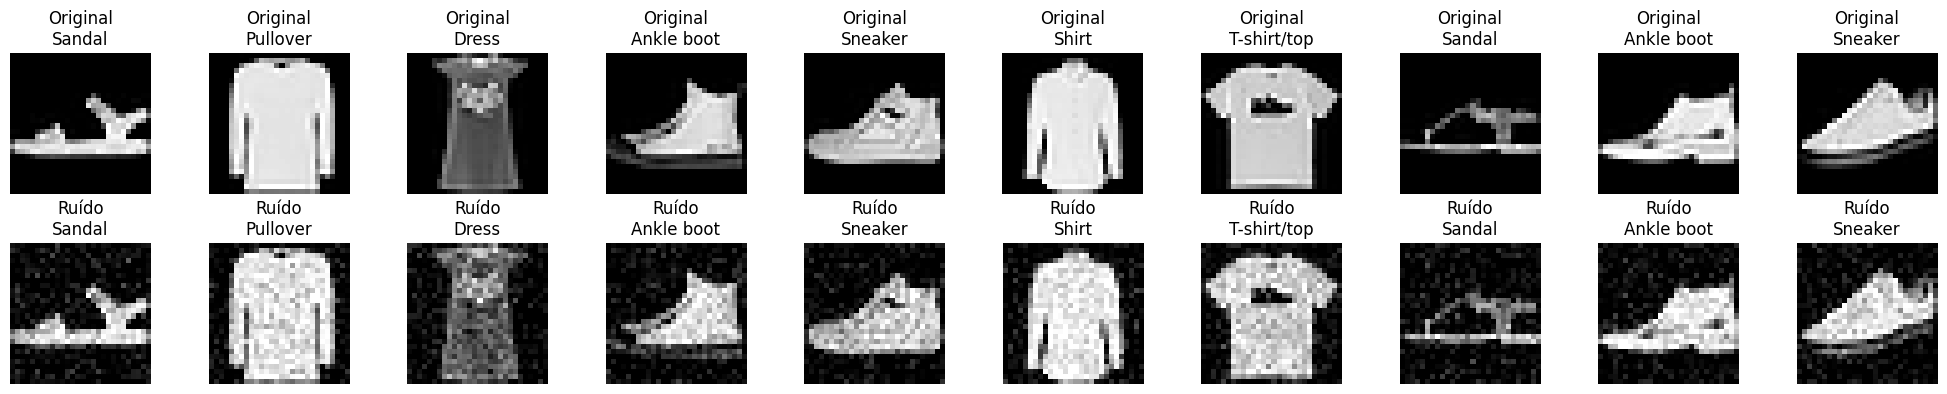

In [119]:
fig, ax = plt.subplots(2, 10, figsize=(20, 4))

for i in range(10):
    # Linha 1: Imagens originais
    ax[0, i].imshow(X_train[i], cmap='gray')
    ax[0, i].set_title(f"Original\n{labeldict[y_train[i]]}")
    ax[0, i].axis('off')

    # Linha 2: Imagens com ruído
    ax[1, i].imshow(train_images_noisy[i], cmap='gray')
    ax[1, i].set_title(f"Ruído\n{labeldict[y_train[i]]}")
    ax[1, i].axis('off')

plt.tight_layout()
plt.show()

In [120]:
## input layer
input_layer = Input(shape=(28,28, 1))

## encoding architecture
encode_layer1 = Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
encode_layer1 = MaxPool2D((2, 2))(encode_layer1)

encode_layer2 = Conv2D(32, (3, 3), activation='relu', padding='same')(encode_layer1)
encode_layer2 = MaxPool2D((2, 2))(encode_layer2)

encode_layer3 = Conv2D(16, (3, 3), activation='relu', padding='same')(encode_layer2)

## latent view
latent_view   = MaxPool2D((2, 2), padding='same')(encode_layer3)

## decoding architecture
decode_layer1 = Conv2D(16, (3, 3), activation='relu', padding='same')(latent_view)
decode_layer1 = UpSampling2D((2, 2))(decode_layer1)

decode_layer2 = Conv2D(32, (3, 3), activation='relu', padding='same')(decode_layer1)
decode_layer2 = UpSampling2D((2, 2))(decode_layer2)

decode_layer3 = Conv2D(64, (3, 3), activation='relu', padding='same')(decode_layer2)
decode_layer3 = UpSampling2D((2, 2))(decode_layer3)


output_layer  = Conv2D(1, (3, 3), padding='same')(decode_layer3)

model = Model(input_layer, output_layer)

In [121]:
model.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)          │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_60 (Conv2D)                   │ (None, 28, 28, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_27 (MaxPooling2D)      │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_61 (Conv2D)                   │ (None, 14, 14, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_28 (MaxPooling2D)      │ (None, 7, 7, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_62 (Conv2D)                   │ (None, 7, 7, 16)            │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_29 (MaxPooling2D)      │ (None, 4, 4, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_63 (Conv2D)                   │ (None, 4, 4, 16)            │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_24 (UpSampling2D)      │ (None, 8, 8, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_64 (Conv2D)                   │ (None, 8, 8, 32)            │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_25 (UpSampling2D)      │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_65 (Conv2D)                   │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_26 (UpSampling2D)      │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_66 (Conv2D)                   │ (None, 32, 32, 1)           │             577 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 49,761 (194.38 KB)

 Trainable params: 49,761 (194.38 KB)

 Non-trainable params: 0 (0.00 B)

In [112]:
model.compile(optimizer='adam', loss='mse')
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')
model.fit(train_images_noisy, train_images_noisy, epochs=20, batch_size=2048, validation_data=(val_images_noisy, val_images_noisy), callbacks=[early_stopping])

Epoch 1/20


ValueError: Dimensions must be equal, but are 28 and 32 for '{{node compile_loss/mse/sub}} = Sub[T=DT_FLOAT](data_1, functional_10_1/conv2d_59_1/Add)' with input shapes: [?,28,28,1], [?,32,32,1].

In [1]:
model = Sequential()
# encoder network
model.add(Conv2D(35, 3, activation= 'relu', padding='same', input_shape = (28,28,1)))
model.add(MaxPooling2D(2, padding= 'same'))
model.add(Conv2D(25, 3, activation= 'relu', padding='same'))
model.add(MaxPooling2D(2, padding= 'same'))
#decoder network
model.add(Conv2D(25, 3, activation= 'relu', padding='same'))
model.add(UpSampling2D(2))
model.add(Conv2D(35, 3, activation= 'relu', padding='same'))
model.add(UpSampling2D(2))
model.add(Conv2D(1,3,activation='sigmoid', padding= 'same')) # output layer
model.compile(optimizer= 'adam', loss = 'mse')
model.fit(train_images_noisy, train_images_noisy,
                epochs=15,
                batch_size=128,
                validation_data=(test_images_noisy, test_images_noisy))

NameError: name 'Sequential' is not defined